# Background

Individual radar reflections are rarely used as a final data product.
Instead, synthetic aperture radar (SAR) focusing is used to improve the spatial resolution by coherently stacking traces within a prescribed ''aperture'' (number of neighboring traces).
The most common SAR focusing algorithms (e.g., the ''standard'' product from the Center for Remote Sensing and Integrated Systems, CReSIS) are optimized for diffuse reflectors, assuming that the same feature can create an observable echo from multiple directions.
Then, data are coherently stacked along a hyperbola to ''focus'' the data (commonly done in the frequency domain).
Focused products work well for the bed echo which is rough at the radar wavelength and therefore diffuse.
However, the specular englacial echoes are not always well resolved in these products.
In fact, the hyperbolic stacking can create destructive interference in dipping layers---in some cases causing them to vanish entirely.
As an alternative, {cite}`castelletti2019layer` proposed a ''layer-optimized''' SAR (LOSAR) algorithm which stacks along a linear dip angle within the synthetic aperture.
The authors demonstrated the algorithm with a single dataset from the British Antarctic Survey (BAS), but it is applicable to any phase-coherent profiling radar sounder.



range to target
$$ r = \sqrt{r_0^2 + (x-x_0)^2} $$

Snell's Law
$$ \mathrm{sin}\theta_1 = n\mathrm{sin}\theta_2 $$

range and phase functions across full aperture
$$ r = \frac{h}{\mathrm{cos}\theta_{1}} + \frac{nd}{\mathrm{cos}\theta_{2}} $$

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [82]:
def raybend(r0,h,x,theta=0.,n=1.72):
    # aperture center
    theta_ice = np.arcsin(np.sin(theta)/n)  # refraction at air-ice interface
    r0_air = h/np.cos(theta)
    r0_ice = r0-r0_air
    
    # closest approach
    d = r0_ice*np.cos(theta_ice) # true depth in ice
    r_ca = d+h
    x_ca = r0_air*np.sin(theta)+r0_ice*np.sin(theta_ice)

    # propagation angles for air and ice across the full aperture
    delta_air =  np.arctan((x-x_ca)/(h+d/n)) # todo, this is assumes a small angle approximation
    delta_ice = np.arcsin(np.sin(delta_air)/n)

    # range and phase functions across full aperture
    r = h/np.cos(delta_air) + d/(np.cos(delta_ice))
    return r,r_ca,x_ca

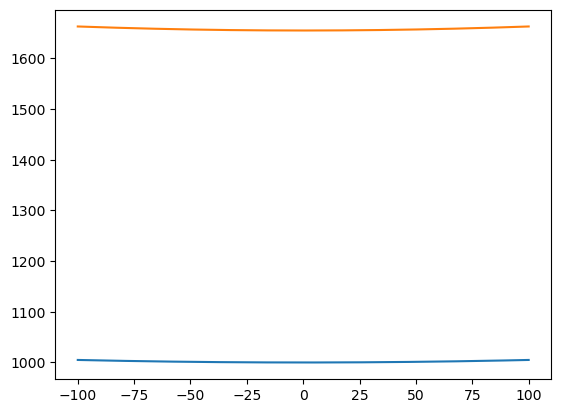

In [83]:
# known geometry
x = np.linspace(-100,100,10000)
r0 = 1000.

plt.figure()
# zero squint and ice surface at the sounding target
θ_sq = 0.*np.pi/180.
h = r0
r,r_ca,x_ca = raybend(r0,h,x,θ_sq)
plt.plot(x,r)
# raise the ice surface
h = 90.
r,r_ca,x_ca = raybend(r0,h,x,θ_sq)
plt.plot(x,r)
# non-zero squint angle
θ_sq = 5.*np.pi/180.
r,r_ca,x_ca = raybend(r0,h,x,θ_sq)
#plt.plot(x,r)

In [ ]:
def matched_filter(r,r_ca,c=3e8,fc=100e6):
    # phase
    ϕ = 4*np.pi*fc*(r-r_ca)/c
    # matched filter
    C = np.exp(-1j*ϕ)
    return ϕ,C

/Users/benhills/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


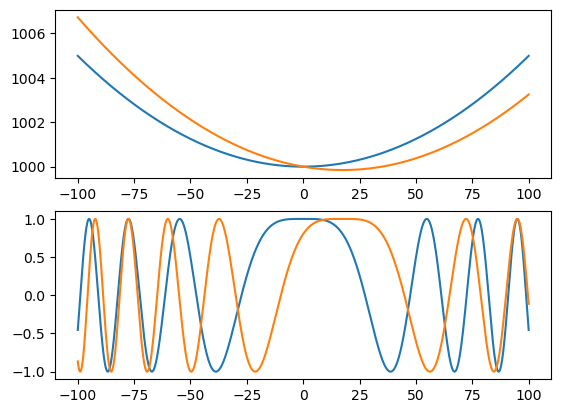

In [3]:
# Range matched filter in air

plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

# constants
c = 3e8
fc = 100e6
ω = 2.*np.pi*fc

# known geometry
x = np.linspace(-100,100,10000)
r0=1000.

# calculate matched filter for no squint
θ_sq = 0.*np.pi/180.
r,ϕ,C = get_matched_filter(r0,θ_sq,x)
ax1.plot(x,r)
ax2.plot(x,C)

# calculate matched filter for no squint
θ_sq = 1.*np.pi/180.
r,ϕ,C = get_matched_filter(r0,θ_sq,x)
ax1.plot(x,r)
ax2.plot(x,C)

In [68]:
def mf(r0,x,theta=0.,n=1.72,c=3e8,fc=100e6):
    # calculated geometry
    r_ca = r0*np.cos(theta)
    x_ca = r_ca*np.tan(theta)
    
    # expected range and phase along track
    r = np.sqrt(r_ca**2. + (x-x_ca)**2.)
    ϕ = 4.*np.pi*fc*(r-r_ca)/c
    
    # to be used for matched filter
    C = np.exp(-1j*ϕ)

    return r,ϕ,C



In [69]:
# known geometry
x = 10
r0 = 1000.
h = 1000.
θ_sq = 0.*np.pi/180.

# calculate standard matched filter for no squint
r,ϕ,C = mf(r0,x,θ_sq)
print(r,ϕ,C)

# calculate standard matched filter for no squint
r,ϕ,C = mf_raybend(r0,h,x,θ_sq)
print(r,ϕ,C)

1000.0499987500625 0.209434274513421 (0.978148689289023-0.20790656950218386j)
1000.0499987500625 0.209434274513421 (0.978148689289023-0.20790656950218386j)


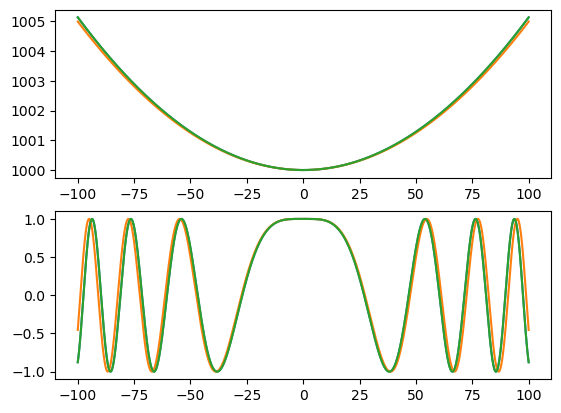

In [78]:
# Range matched filter with two media (no squint)

plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

# known geometry
x = np.linspace(-100,100,10000)
r0 = 1000.
θ_sq = 0.*np.pi/180.
h = 990

# calculate standard matched filter for no squint
r,ϕ,C = mf_raybend(r0,h,x,θ_sq)
ax1.plot(x,r)
ax2.plot(x,C)

θ_sq = 0*np.pi/180.
# calculate standard matched filter for no squint
r,ϕ,C = mf(r0,x,θ_sq)
ax1.plot(x,r)
ax2.plot(x,C)

# known geometry
r,ϕ,C = mf_raybend(r0,h,x,θ_sq)
ax1.plot(x,r)
ax2.plot(x,C)

999.9963889408343 2.6249732881203105


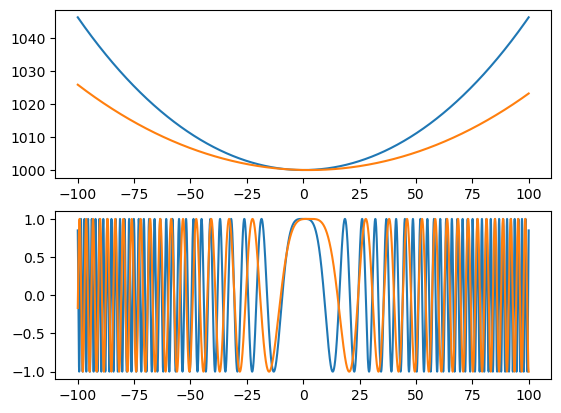

In [67]:
# Range matched filter with two media (no squint)

plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)


# constants
c = 3e8
fc = 100e6
ω = 2.*np.pi*fc
n = 1.72

# known geometry
x = np.linspace(-100,100,10000)
r0 = 1000.
d_air = 300.
θ_sq = 0.*np.pi/180.

# calculate standard matched filter for no squint
r,ϕ,C = get_matched_filter(r0,θ_sq,x)
ax1.plot(x,r)
ax2.plot(x,C)

θ_sq = .1*np.pi/180.

# refraction
θ0_air = θ_sq
θ0_ice = np.arcsin(n*np.sin(θ0_air))

# calculated geometry
r0_air = d_air/np.cos(θ0_air)
r0_ice = r0-r0_air
d_ice = r0_ice*np.cos(θ0_ice)
r_ca = d_ice+d_air
x_ca = r0_air*np.sin(θ0_air)+r0_ice*np.sin(θ0_ice)

print(r_ca,x_ca)

θ_air =  (x-x_ca)/(d_air+d_ice/n)
θ_ice = np.arcsin(n*np.sin(θ_air))

r = d_air/np.cos(θ_air) + d_ice/np.cos(θ_ice)

"""
# ray bending equations
d_ice = r0 - d_air
θ_air =  x/(d_air+d_ice/n)
θ_ice = np.arcsin(n*np.sin(θ_air))

# expected range and phase along track
r = d_air/np.cos(θ_air) + d_ice/np.cos(θ_ice)
"""
ϕ = 2*ω*(r-r_ca)/c


# to be used for matched filter
C = np.exp(-1j*ϕ)

ax1.plot(x,r)
ax2.plot(x,C)

In [47]:
x = 10
r0 = 1000.
theta=0.*np.pi/180.
n=1.72
c=3e8
fc=100e6

# calculated geometry
r_ca = r0*np.cos(theta)
x_ca = r_ca*np.tan(theta)

print(r_ca,x_ca)




# aperture center
theta_ice = np.arcsin(np.sin(theta)/n)  # refraction at air-ice interface
r0_air = h/np.cos(theta)
r0_ice = r0-r0_air

# closest approach
d = r0_ice*np.cos(theta_ice) # true depth in ice
r_ca = d+h
x_ca = r0_air*np.sin(theta)+r0_ice*np.sin(theta_ice)

# propagation angles for air and ice across the full aperture
delta_air =  (x-x_ca)/(h+d/n)
delta_ice = np.arcsin(n*np.sin(delta_air))

print(r_ca,x_ca)

"""
# expected range and phase along track
r = np.sqrt(r_ca**2. + (x-x_ca)**2.)
ϕ = 4.*np.pi*fc*(r-r_ca)/c

# to be used for matched filter
C = np.exp(-1j*ϕ)
"""


def mf_raybend(r0,h,x,theta=0.,n=1.72,c=3e8,fc=100e6):



    # propagation angles for air and ice across the full aperture
    delta_air =  (x-x_ca)/(h+d/n)
    delta_ice = np.arcsin(n*np.sin(delta_air))

    # range and phase functions across full aperture
    r = h/np.cos(delta_air) + d/np.cos(delta_ice)
    ϕ = 4*np.pi*fc*(r-r0)/c
    
    # matched filter
    C = np.exp(-1j*ϕ)

    return r,ϕ,C

1000.0 0.0
1000.0 0.0


In [75]:
x = 0.
r0 = 1000.
theta = 1.*np.pi/180.
h = 990. #r0*np.cos(theta)
#h = r0/10.
n=1.77

# aperture center
theta_ice = np.arcsin(np.sin(theta)/n)  # refraction at air-ice interface
r0_air = h/np.cos(theta)
r0_ice = r0-r0_air

# closest approach
d = r0_ice*np.cos(theta_ice) # true depth in ice
r_ca = d+h
x_ca = r0_air*np.sin(theta)+r0_ice*np.sin(theta_ice)

# propagation angles for air and ice across the full aperture
delta_air =  np.arctan((x-x_ca)/(h+d/n)) # todo, this is assumes a small angle approximation
delta_ice = np.arcsin(np.sin(delta_air)/n)

# range and phase functions across full aperture
r = h/np.cos(delta_air) + d/(np.cos(delta_ice))

print(delta_air*180/np.pi,delta_ice*180/np.pi)

# range and phase functions across full aperture
r = h/np.cos(delta_air) + d/np.cos(delta_ice)

-0.9999994205469906 -0.5649518956760693


In [76]:
h+d

999.8487164461568